## Embedding
We start by developing an embedding of a dictionary. Since all potential words and misspellings that are in tweets would create an extremely large, but sparse vector, this would not be an efficient way of storing data.

The most common solution is to represent each word in the vocabulary using a fairly small and dense vector called an *embedding*, and just let the neural network learn a good embedding for each word during training. At the beginning of training, embeddings are simply chosen randomly, but during training, backpropagation automatically moves the embeddings around in a way that helps the neural network perform its task. This means that similar words will gradually cluster close to one another, and even end up organized in a rather meaningful way. Embeddings may end up placed along various axes that represent gender, singular/plural, adjective/noun, etc.

We first need to create the variable representing the embedding, then if we feed a sentence to the neural network, we first preprocess the sentence and break it into a list of known words. We may remove unnecessary characters, replace unknown words by a predefined token word such as "[UNK]", replace numerical values by "[NUM]", replace URLs with "[URL]", and so on. Once we have a list of known words, we can look up each word's integer identifier in a dictionary. At that point we are ready to feed these word identifiers to TensorFlow using a placeholder, and apply the `embedding_lookup()` function to get the corresponding embeddings.

Once our model has learned good word embeddings, they can actually be reused fairly efficiently in any NLP application. In fact, instead of training our own word embeddings, we may want to download pretrained word embeddings (like using pretrained layers, we can choose to freeze the pretrained embeddings by creating an `embeddings` variable using `trainable = False`, or let backpropagation tweak them for our application. The first option will speed up training, but the second may lead to slightly higher performance.

We form the dictionary from tweets scraped by keyword (list of 50 terms in `data-cleaner.ipynb`), and data collected from `twitter_samples` of the Natural Language Toolkit (`nltk`) database.

In [3]:
import tensorflow as tf
import numpy as np
import pandas as pd
import nltk
import glob
import string
import matplotlib.pyplot as plt
import matplotlib as mpl

nltk.download('punkt')

#import errno
#import os
#import zipfile

def reset_graph(seed = 42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\debro\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
# NLTK tweets
from nltk.corpus import twitter_samples

In [5]:
twitter_samples.strings()[:5]

['hopeless for tmr :(',
 "Everything in the kids section of IKEA is so cute. Shame I'm nearly 19 in 2 months :(",
 '@Hegelbon That heart sliding into the waste basket. :(',
 '“@ketchBurning: I hate Japanese call him "bani" :( :(”\n\nMe too',
 'Dang starting next week I have "work" :(']

In [6]:
tweets = twitter_samples.tokenized()
tweet_dict = []
for i in range(len(tweets)):
    for j in range(len(tweets[i])):
        tweet_dict.append(tweets[i][j])


print(tweet_dict[:15])

['hopeless', 'for', 'tmr', ':(', 'Everything', 'in', 'the', 'kids', 'section', 'of', 'IKEA', 'is', 'so', 'cute', '.']


## JAYARAM: Polarity Measure

The way I see the usage of this, is that we can _potentially_ use this as another input variable for our neural network. We first will have to look at the measure of polarity and its relationship to tweets' "water issue relevance". If we find that there is a strong correlation between relevance and polarity and we can justify that relationship, then we should probably use that as an input. If you can input this into our Pandas DataFrame `all_csvs` (first 5 rows seen below) as a column, `polarity`, that would be excellent.

In [7]:
# Making a list directory of all the tweets we have collected
files_0 = glob.glob('./datasets/water_tweets/gathered_water/*.csv')
water1_tweets = pd.read_csv('./datasets/water_tweets/water1.csv', encoding = 'ISO-8859-1', delimiter = ',')

# loading JSON files
from pandas.io.json import json_normalize
with open('datasets/water_tweets/gathered_water/water8.json', 'r', encoding="utf-8") as json_file:
    water_json_1 = pd.read_json('datasets/water_tweets/gathered_water/water8.json', typ='object', orient='columns')
    water_json_1 = pd.io.json.json_normalize(water_json_1)
    water_json_1 = water_json_1[['text', 'timestamp']]

with open('datasets/water_tweets/gathered_water/water9_drought.json', 'r', encoding = 'utf-8') as json_file:
    water_json_2 = pd.read_json('datasets/water_tweets/gathered_water/water9_drought.json', typ='object', orient='columns')
    water_json_2 = pd.io.json.json_normalize(water_json_2)
    water_json_2 = water_json_2[['text', 'timestamp']]

water_jsons = pd.concat([water_json_1, water_json_2])
water_jsons.columns = ['text', 'date']
water_jsons['retweet_count'] = np.nan
water_jsons['category'] = np.nan
water_jsons['tweet_id'] = np.nan
water_jsons = water_jsons[['category', 'date', 'text', 'retweet_count', 'tweet_id']]

# Loading uniformly formatted pulled tweets
water_csvs = pd.concat([pd.read_csv(f, encoding = 'ISO-8859-1', delimiter = ';') for f in files_0])
water_csvs = pd.concat([water1_tweets, water_csvs, water_jsons])
water_csvs = water_csvs[['category', 'date', 'text', 'retweet_count', 'tweet_id']]
water_csvs = water_csvs[water_csvs['text'] != 'text']
water_csvs = water_csvs[water_csvs['category'] != 'pcb']
water_csvs = water_csvs[water_csvs['category'] != 'benzene']
files_1 = glob.glob('./datasets/water_tweets/rnd_tweets/*.csv')
rnd_csvs = pd.concat([pd.read_csv(f, encoding = 'ISO-8859-1', delimiter = ';') for f in files_1])
rnd_csvs = rnd_csvs[['category', 'date', 'text', 'retweet_count', 'tweet_id']]
rnd_csvs = rnd_csvs[rnd_csvs['text'] != 'text']
all_csvs = pd.concat([water_csvs, rnd_csvs])
all_csvs['text'] =  all_csvs['text'].astype(str)
all_csvs = all_csvs.drop_duplicates(subset = ['text'], keep = 'first').reset_index()
all_csvs = all_csvs.iloc[:, 1:]
#all_csvs.columns = ['category', 'date', 'tweet', 'retweet_count', 'tweet_id']
print(len(all_csvs))

all_csvs.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



415708


,category,date,text,retweet_count,tweet_id
0,flash flood,6/25/2019 20:45,@LeslieWalden6 @MookieTheBrave @AngusMcPussPus...,0.0,1.140000e+18
1,flash flood,6/25/2019 20:28,4 PASSES to FLASH FLOOD WATER PARK in Battle C...,0.0,1.140000e+18
2,flash flood,6/25/2019 20:21,So the maintenance men at my apartment complex...,0.0,1.140000e+18
3,flash flood,6/25/2019 20:07,".@NWStulsa issued 1,530 flood/flash flood prod...",0.0,1.140000e+18
4,flash flood,6/25/2019 19:55,"They might not call it a #climatedebate, but c...",0.0,1.140000e+18


In [8]:
tweet_text = list(all_csvs.text.astype(str))
print(tweet_text[:5])

["@LeslieWalden6 @MookieTheBrave @AngusMcPussPuss @AngelaStillwell @cat_samson @arkantart @Biscuit_Meow @duchess_meow @TobiasandJasper @goodman_carina It's cwazy!! Mom tiwed of seeing flash flood warnings fwom The Weather Channel pop up on her phone evewyday. She appweciates the warning, but she knows which aweas are pwone to flooding.ð\x9f\x98¼ð\x9f\x98¼", '4 PASSES to FLASH FLOOD WATER PARK in Battle Creek, MICHIGAN - 2019 season!!! $12.00 | #WaterparkTickets | https://t.co/tIumVg5T0d Grab Your Tickets https://t.co/UQNz5zZ7vC', 'So the maintenance men at my apartment complex are leaf blowing during a flash flood warning... https://t.co/YkWkVzTvSy', '.@NWStulsa issued 1,530 flood/flash flood products in May 2019 alone!  Includes new warnings/advisories + all follow up statements #okwx #arwx https://t.co/3M9GfJyuez', 'They might not call it a #climatedebate, but considering that the venue where 20 Democrats are meeting in Miami this week was once inundated during a flash flood, it kind

In [9]:
# Tokenizing the tweet words
for i in range(len(tweet_text)):
    tweet = tweet_text[i]
    tweet = tweet.translate(str.maketrans('','', string.punctuation))
    tweet = tweet.split()
    for j in range(len(tweet)):
        new_word = tweet[j]
        tweet_dict.append(new_word)

In [10]:
print(len(tweet_dict))
new_tweet_dict = []
for i in range(len(tweet_dict)):
    word = tweet_dict[i]
    word = word.translate(str.maketrans('', '', string.punctuation))
    word = word.lower()
    new_tweet_dict.append(word)
new_tweet_dict[786085:786110]

10994499


['the',
 'bath',
 'all',
 'taps',
 'have',
 'isolation',
 'valves',
 'except',
 'the',
 'leaky',
 'bath',
 '12',
 'httpstcouc3aoh0iwe',
 'sweatienext',
 'he',
 'did',
 'come',
 'by',
 'today',
 'amp',
 'check',
 'the',
 'ceiling',
 'no',
 'nest']

## Build Our Dictionary

In [11]:
from collections import Counter

vocabulary_size = 50000

# UNK = unknown words, HST = hashtag, EMT = emoticon, URL is self-explanatory, THDL = Twitter handle
vocabulary = [("<UNK>", None)] + [("<HST>", None)] + [("<EMT>", None)] + [("<URL>", None)] + [("<THDL>", None)] +\
            Counter(new_tweet_dict).most_common(vocabulary_size - 1)
vocabulary = np.array([word for word, _ in vocabulary])
dictionary = {word: code for code, word in enumerate(vocabulary)}
data = np.array([dictionary.get(word, 0) for word in new_tweet_dict])
print(len(vocabulary))
#print(len(data))

50004


In [12]:
" ".join(new_tweet_dict[:9]), data[:9]

('hopeless for tmr  everything in the kids section',
 array([10370,    14, 25172,    17,   284,    12,     5,   351,  2922]))

In [20]:
" ".join([vocabulary[word_index] for word_index in [10370,    14, 25172,    17,   284,    12,     5,   351,  2922]])

'hopeless for tmr  everything in the kids section'

## Generate Batches

In [21]:
from collections import deque

def generate_batch(batch_size, num_skips, skip_window):
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch = np.ndarray(shape=[batch_size], dtype=np.int32)
    labels = np.ndarray(shape=[batch_size, 1], dtype=np.int32)
    span = 2 * skip_window + 1 # [ skip_window target skip_window ]
    buffer = deque(maxlen=span)
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    for i in range(batch_size // num_skips):
        target = skip_window  # target label at the center of the buffer
        targets_to_avoid = [ skip_window ]
        for j in range(num_skips):
            while target in targets_to_avoid:
                target = np.random.randint(0, span)
            targets_to_avoid.append(target)
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[target]
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    return batch, labels

In [22]:
np.random.seed(42)

data_index = 0
batch, labels = generate_batch(8, 2, 1)

In [23]:
batch, [vocabulary[word] for word in batch]

(array([   14,    14, 25172, 25172,    17,    17,   284,   284]),
 ['for', 'for', 'tmr', 'tmr', '', '', 'everything', 'everything'])

In [24]:
labels, [vocabulary[word] for word in labels[:, 0]]

(array([[25172],
        [10370],
        [   17],
        [   14],
        [25172],
        [  284],
        [   12],
        [   17]]),
 ['tmr', 'hopeless', '', 'for', 'tmr', 'everything', 'in', ''])

In [25]:
reset_graph()
batch_size = 128
embedding_size = 128  # Dimension of the embedding vector.
skip_window = 1       # How many words to consider left and right.
num_skips = 2         # How many times to reuse an input to generate a label.

# We pick a random validation set to sample nearest neighbors. Here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent.
valid_size = 32     # Random set of words to evaluate similarity on.
valid_window = 100  # Only pick dev samples in the head of the distribution.
valid_examples = np.random.choice(valid_window, valid_size, replace=False)
num_sampled = 64    # Number of negative examples to sample.

learning_rate = 0.01

In [26]:
#reset_graph()

# Input data.
train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

vocabulary_size = 50004
embedding_size = 128

# Look up embeddings for inputs.
init_embeds = tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0)
embeddings = tf.Variable(init_embeds)

train_inputs = tf.placeholder(tf.int32, shape=[None])
embed = tf.nn.embedding_lookup(embeddings, train_inputs)

# Construct the variables for the NCE loss
nce_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                        stddev=1.0 / np.sqrt(embedding_size)))
nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

# Compute the average NCE loss for the batch.
# tf.nce_loss automatically draws a new sample of the negative labels each
# time we evaluate the loss.
loss = tf.reduce_mean(
    tf.nn.nce_loss(nce_weights, nce_biases, train_labels, embed,
                   num_sampled, vocabulary_size))

# Construct the Adam optimizer
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

# Compute the cosine similarity between minibatch examples and all embeddings.
norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), axis=1, keepdims=True))
normalized_embeddings = embeddings / norm
valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
similarity = tf.matmul(valid_embeddings, normalized_embeddings, transpose_b=True)

# Add variable initializer.
init = tf.global_variables_initializer()

In [27]:
num_steps = 40001

with tf.Session() as session:
    init.run()

    average_loss = 0
    for step in range(num_steps):
        print("\rIteration: {}".format(step), end="\t")
        batch_inputs, batch_labels = generate_batch(batch_size, num_skips, skip_window)
        feed_dict = {train_inputs : batch_inputs, train_labels : batch_labels}

        # We perform one update step by evaluating the training op (including it
        # in the list of returned values for session.run()
        _, loss_val = session.run([training_op, loss], feed_dict=feed_dict)
        average_loss += loss_val

        if step % 2000 == 0:
            if step > 0:
                average_loss /= 2000
            # The average loss is an estimate of the loss over the last 2000 batches.
            print("Average loss at step ", step, ": ", average_loss)
            average_loss = 0

        # Note that this is expensive (~20% slowdown if computed every 500 steps)
        if step % 20000 == 0:
            sim = similarity.eval()
            for i in range(valid_size):
                valid_word = vocabulary[valid_examples[i]]
                top_k = 8 # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k+1]
                log_str = "Nearest to %s:" % valid_word
                for k in range(top_k):
                    close_word = vocabulary[nearest[k]]
                    log_str = "%s %s," % (log_str, close_word)
                print(log_str)

    final_embeddings = normalized_embeddings.eval()

Iteration: 0	Average loss at step  0 :  290.974853515625
Nearest to him: moraygreig, posts, backstabbing, heâd, assert, 2011, acesso, rhythm,
Nearest to who: surveillance, sneaky, frown, redeem, thankyoucbnforkia, apocalyptic, ã, angryjoeshow,
Nearest to am: earlybiz, doctoreon, trabajar, shutting, unforeseen, nearing, onsite, jo,
Nearest to she: baffled, 56th, barely, squat, borderpatrol, nuevas, actual, extent,
Nearest to from: legit, âhaha, pressures, communicates, bridget, ataque, secret, anymore,
Nearest to just: serialsockthief, shelaghfogarty, âim, specialty, starke, hailey, wan, adversely,
Nearest to water: ppm, waterleak, diciendo, packets, hillaryâs, theage, crumbles, bugwannostra,
Nearest to been: grenades, mourinho, 200am, trousdale, friction, braindead, michaelrapaport, alpha,
Nearest to of: crl, calybo62, genflynn, kinda, travã©s, hem, thelindsayellis, just,
Nearest to <UNK>: missions, applications, agus, mining, newt, ozraeliavi, i, apprentice,
Nearest to on: w

Nearest to at: on, <UNK>, for, à¤¸à¥à¤¨à¤¾, july, in, plagued, bayan,
Nearest to people: a, water, attitude, <UNK>, complicate, that, really, him,
Nearest to itâs: not, <UNK>, i, swallow, its, you, it, everglades,
Nearest to was: , water, onegallon, is, also, stec, can, 837,
Nearest to all: the, this, <UNK>, that, disturbing, , leachate, in,
Nearest to his: my, the, lungs, it, your, italy, dry, alt,
Nearest to it: the, water, not, , a, its, <UNK>, that,
Nearest to what: why, <UNK>, do, the, that, , it, you,
Nearest to really: it, <UNK>, mdt, not, you, i, dont, be,
Nearest to i: you, it, we, that, <UNK>, not, he, drinking,
Nearest to now: not, it, wud, the, septictank, <UNK>, b4, parasites,
Nearest to you: we, do, i, that, it, spill, not, the,
Nearest to an: the, <UNK>, spill, a, flawless, pills, disturbing, not,
Iteration: 22000																																																																																																																																																													

In [28]:
np.save("./my_final_embeddings_tweets.npy", final_embeddings)

## Plotting the Embedding

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 128 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 153 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 128 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 153 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 159 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 152 missing from current font.
  f

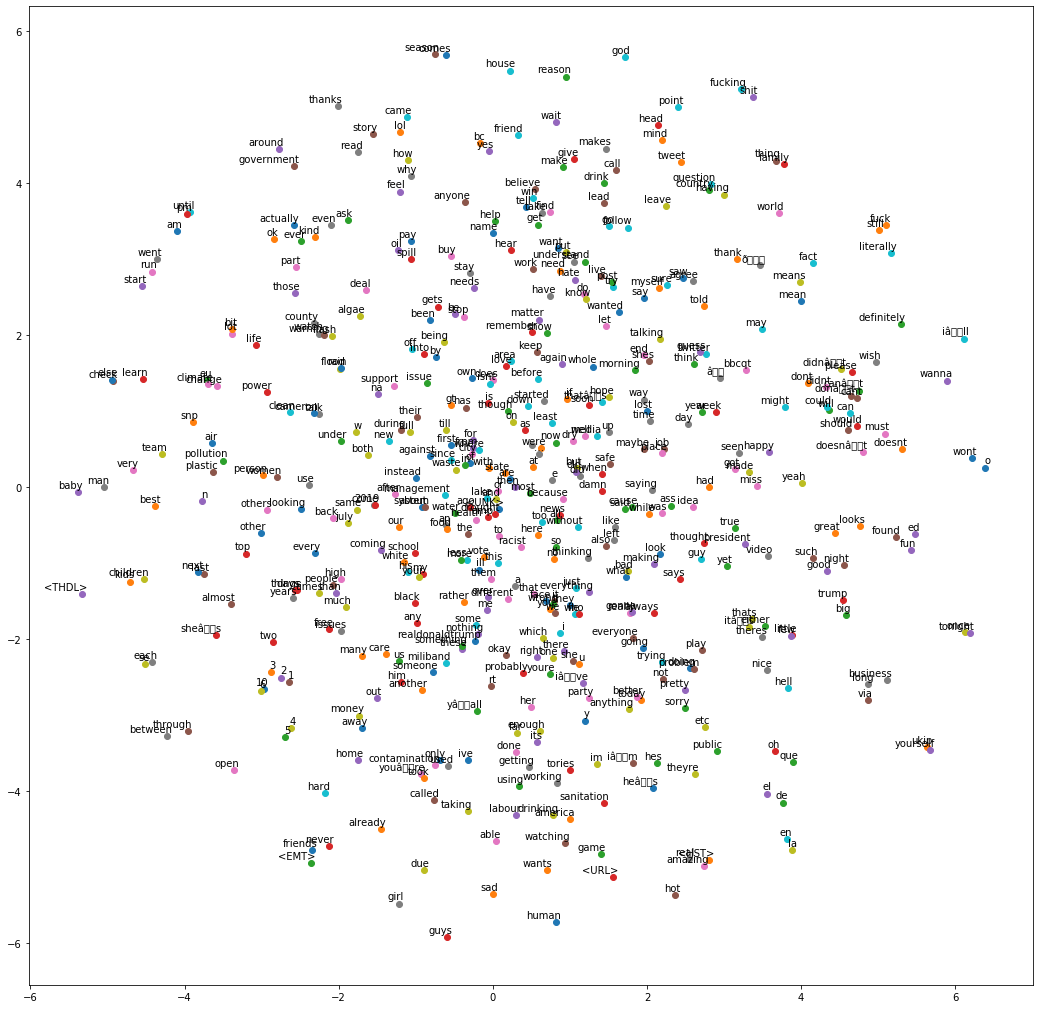

In [29]:
def plot_with_labels(low_dim_embs, labels):
    assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
    plt.figure(figsize=(18, 18))  #in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i,:]
        plt.scatter(x, y)
        plt.annotate(label,
                     xy=(x, y),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
        
from sklearn.manifold import TSNE

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
plot_only = 500
low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only,:])
labels = [vocabulary[i] for i in range(plot_only)]
plot_with_labels(low_dim_embs, labels)

## Randomly Sampling the Gathered Tweets
Skip unless called?

In [31]:
def rnd_sample_csv(dataframe, size, keyword_type, num):
    
    '''dataframe needs to be a pandas dataframe,
    size is the number we are randomly sampling, should be an integer,
    keyword needs to be a string,
    num is the number of the file, should be an integer'''
    
    sampled_df = dataframe.sample(n = size, replace = False, random_state = 42)
    path = "datasets/water_tweets/sampled_tweets"
    file_name = "sampled_tweets_" + str(keyword_type) + '_' + str(num) + ".csv"
    sampled_df.to_csv(str(path) + '/' + str(file_name), sep = ';')

In [32]:
rnd_sample_csv(water_csvs, 2500, 'water', 1)
#rnd_sample_csv(all_csvs, 20000, 'all', 0)

## CNN for Prediction
# Chapter 13-Convolutional Neural Networks
**Convolutional neural networks (CNNs)** emerged from the study of the brain's visual cortex, and they have been used in image recognition since the 80s. CNNs have managed to achieve superhuman performance on some complex visual tasks. They are a powerful tools for *voice recognition* and ***natural language processing (NLP)***.
## Architecture of the Visual Cortex
Hubel and Wiesel showed that many neurons in the visual cortex have a small *local receptive field*, meaning they react only to visual stimuli located in a limited region of the visual field. The receptive fields of different neurons showed that some neurons react only to images of horizontal lines, while others react only to lines with different orientations. They noticed that some neurons have larger receptive fields, and they react to more complex patterns that are combinations of the lower-level patterns. These observations led to the ideda that higher-level neurons are based on the outputs of neighboring lower-level neurons. This powerful architecture is able to detect all sorts of complex patterns in any area of the visual field. LeCun, Bottou, Bengio, and Haffner introduced the famous *LeNet-5* architecture. This has building blocks that we already know, like the fully connected layers and sigmoid activation functions, but it also introduces two new building blocks: *convolutional layers* and *pooling layers*.
## Convolutional Layer
The most important building block of a CNN is the *convolutional layer*: neurons in the first convolutional layer are not connected to every single pixel in the input image, but only to pixels in their receptive fields. In turn each neuron in the second convolutional layer is connected only to neurons located within a small rectangle in the first layer. This architecture allows the netowrk to concentrate on low-level features in the first hidden layer, then assemble them into higher-level features in the next hidden layer, and so on. This hierarchical structure is common in real-world images, which is one of the reasons why CNNs work well for image recognition.

## TensorFlow Implementation
In TensorFlow, each tweet is typically represented as a 2D tensor pf shape `[length, channels]`. A mini-batch is represented as a 3D tensor of shape `[mini-batch size, length, channels]`. The weights of a convolutional layer are represented as a 3D tensor of shape $[f_l, f_{n'}, f_n]$. The bias terms of a convolutional layer are simply represented as a 1D tensor of shape $[f_n]$.

In [33]:
# Load the data
all_tweets = np.array(all_csvs.text)
water_csvs = water_csvs.drop_duplicates(subset = ['text'], keep = 'first')
water_tweets = np.array(water_csvs.text)
sampled_labeled_tweets = pd.read_csv('./datasets/water_tweets/sampled_tweets/labeled_tweets.csv',
                                    encoding = 'ISO-8859-1', delimiter = ';', header = 0)
print(sampled_labeled_tweets.head())
sampled_labeled_text = np.array(sampled_labeled_tweets.text)

   index         category                 date  \
0    473  water pollution             ########   
1    714              NaN  2011-08-19T23:59:48   
2    386      algae bloom             ########   
3   3203      flash flood             ########   
4   2573   chemical spill             ########   

                                                text  retweet_count  \
0  *@CBSNews Maybe the oil spill...'or water poll...            0.0   
1  Nigga we stranded Lmaoo RT @DAofficialLeXX: Ca...            NaN   
2        *@GabbyEWXXV *@WXXV25 Buh bye, algae bloom!            0.0   
3  Barry spares New Orleans but fuels fears of fl...            0.0   
4  ALERT: People living or working near an #EastR...            0.0   

       tweet_id Decision: Evan  Decision: 1  Decision: 2  Decision: 3  \
0  1.160000e+18              n          NaN          NaN          NaN   
1           NaN              n          NaN          NaN          NaN   
2  1.150000e+18              n          NaN          

In [40]:
# Vectorize the tweets using our trained embedding
str_labeled_tweets = []
lens = []
for i in range(len(sampled_labeled_text)):
    tweet = sampled_labeled_text[i]
    tweet = tweet.translate(str.maketrans('','', string.punctuation))
    tweet = tweet.split()
    str_labeled_tweets.append(tweet)
    lens.append(tweet_len)
    
# Max len is 215?
# probably due to odd characters, need to pad the tweets

[['CBSNews', 'Maybe', 'the', 'oil', 'spillor', 'water', 'pollution', 'or', 'some', 'other', 'man', 'made', 'cause', 'is', 'the', 'reason', 'we', 'havent', 'been', 'kind', 'to', 'our', 'environment'], ['Nigga', 'we', 'stranded', 'Lmaoo', 'RT', 'DAofficialLeXX', 'Car', 'scare', 'of', 'water', 'lolRT', 'IMSOOFAB', 'How', 'we', 'in', 'a', 'cab', 'this', 'shit', 'stops', 'httptmimeeI6NIÃ\x82']]
[23, 23]


In [36]:
def __init__(self, sequence_length, num_classes, vocab_size, embedding_size,
             filter_sizes, num_filters, l2_reg_lambda = 0.0):
    '''
    -sequence_length is the length of the tweet, need to pad them
    -num_classes is the number of classes (relevant and irrelevant)
    -vocab_size is the size of our vocabulary (50004)
    -embedding_size is the dimensionality of our embeddings
    -filter_sizes is the number of words our we want our convolutional filters to cover. We will have 
    num_filters for each size specified here. For example, [3, 4, 5] means that we will have filters 
    that slide over 3, 4 and 5 words respectively, for a total of 3 * num_filters filters.
    -num_filters number of filters per filter size
    '''
    
    # input placeholders
    self.X = tf.placeholder(tf.float32, [None, sequence_length], name = 'X')
    self.y = tf.placeholder(tf.int32, [None, num_classes], name = 'y')
    self.dropout_keep_prob = tf.placeholder(tf.float32, name = 'dropout_keep_prob')
    
    # l2 regularization loss
    l2_loss = tf.constant(0.0)
    
    # define embedding layer
    with tf.device('/cpu:0'), tf.name_scope("embedding"):
        W = tf.Variable(tf.random_uniform([vocab_size, embedding_size], -1.0, 1.0), name="W")
        self.embedded_chars = tf.nn.embedding_lookup(W, self.X)
        self.embedded_chars_expanded = tf.expand_dims(self.embedded_chars, -1)
        
    # Create a convolution + maxpool layer for each filter size
    pooled_outputs = []
    for i, filter_size in enumerate(filter_sizes):
        with tf.name_scope("conv-maxpool-%s" % filter_size):
                # Convolution Layer
                filter_shape = [filter_size, embedding_size, 1, num_filters]
                W = tf.Variable(tf.truncated_normal(filter_shape, stddev=0.1), name="W")
                b = tf.Variable(tf.constant(0.1, shape=[num_filters]), name="b")
                conv = tf.nn.conv2d(
                    self.embedded_chars_expanded,
                    W,
                    strides=[1, 1, 1, 1],
                    padding="VALID",
                    name="conv")
                # Apply nonlinearity
                h = tf.nn.relu(tf.nn.bias_add(conv, b), name="relu")
                # Maxpooling over the outputs
                pooled = tf.nn.max_pool(
                    h,
                    ksize=[1, sequence_length - filter_size + 1, 1, 1],
                    strides=[1, 1, 1, 1],
                    padding='VALID',
                    name="pool")
                pooled_outputs.append(pooled)

        # Combine all the pooled features
        num_filters_total = num_filters * len(filter_sizes)
        self.h_pool = tf.concat(pooled_outputs, 3)
        self.h_pool_flat = tf.reshape(self.h_pool, [-1, num_filters_total])
        
        # Add dropout
        with tf.name_scope("dropout"):
            self.h_drop = tf.nn.dropout(self.h_pool_flat, self.dropout_keep_prob)
            
        # Final (unnormalized) scores and predictions
        with tf.name_scope("output"):
            W = tf.get_variable(
                "W",
                shape=[num_filters_total, num_classes],
                initializer=tf.contrib.layers.xavier_initializer())
            b = tf.Variable(tf.constant(0.1, shape=[num_classes]), name="b")
            l2_loss += tf.nn.l2_loss(W)
            l2_loss += tf.nn.l2_loss(b)
            self.scores = tf.nn.xw_plus_b(self.h_drop, W, b, name="scores")
            self.predictions = tf.argmax(self.scores, 1, name="predictions")
            
        # Calculate mean cross-entropy loss
        with tf.name_scope("loss"):
            losses = tf.nn.softmax_cross_entropy_with_logits(logits=self.scores, labels=self.input_y)
            self.loss = tf.reduce_mean(losses) + l2_reg_lambda * l2_loss

        # Accuracy
        with tf.name_scope("accuracy"):
            correct_predictions = tf.equal(self.predictions, tf.argmax(self.input_y, 1))
            self.accuracy = tf.reduce_mean(tf.cast(correct_predictions, "float"), name="accuracy")